<a href="https://colab.research.google.com/github/Rouic/classification-experiment-ml/blob/main/Test2_multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
!python3 --version

Python 3.10.12


In [167]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, hamming_loss, precision_score, recall_score

# Hyperparameters
learning_rate = 2e-5  # Adjust if needed
batch_size = 16     # Adjust if needed
dropout_rate = 0.2   # Adjust dropout rate (0.1 - 0.5 usually work well)

class TreeClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.dropout = nn.Dropout(dropout_rate) # Dropout layer NOTE : not in use jet the data set is to small
        self.fc = nn.Linear(768, num_classes)  # Adjust input size if using different embeddings

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] token representation
        # pooled_output = self.dropout(pooled_output) # Apply dropout NOTE : not in use jet the data set is to small
        logits = self.fc(pooled_output)
        probabilities = torch.sigmoid(logits)  # Apply sigmoid for multi-label classification
        return probabilities

In [168]:
# UTILS
from timeit import default_timer as timer

def print_train_time(start, end, device=None):
    """ Print traing time """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def getResponse(predicted_labels, threshold):
    """ Print out message """
    if len(predicted_labels) == 0:
      return f"Im not able to confidently answer... sorry. Can you try to rephrase? (trashold: {threshold})"
    else:
      return f" ".join([label_names[i] for i in predicted_labels]) + f" (trashold: {threshold})"

In [169]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [170]:
# Define Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [171]:
texts = ["example text 1 y", "example text 2 y", "example text 3 g", "example text 4 g", "example text 5 p", "example text 6 p", "example text 6 y"]

labels = [
    [1, 0, 0],  # example text 1: belongs to 'y class'
    [1, 0, 0],  # example text 2: belongs to 'y class'
    [0, 1, 0],  # example text 3: belongs to 'g class'
    [0, 1, 0],  # example text 4: belongs to 'g class'
    [0, 0, 1],  # example text 5: belongs to 'p class'
    [0, 0, 1],  # example text 6: belongs to 'p class'
    [1, 0, 1],  # example text 6: belongs to 'y class'
]

labels = np.array(labels)

label_names = [
    "y class",
    "g class",
    "p class"
]

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [172]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = TextDataset(X_train, y_train, tokenizer, max_len=128)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [173]:
test_dataset = TextDataset(X_test, y_test, tokenizer, max_len=128)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

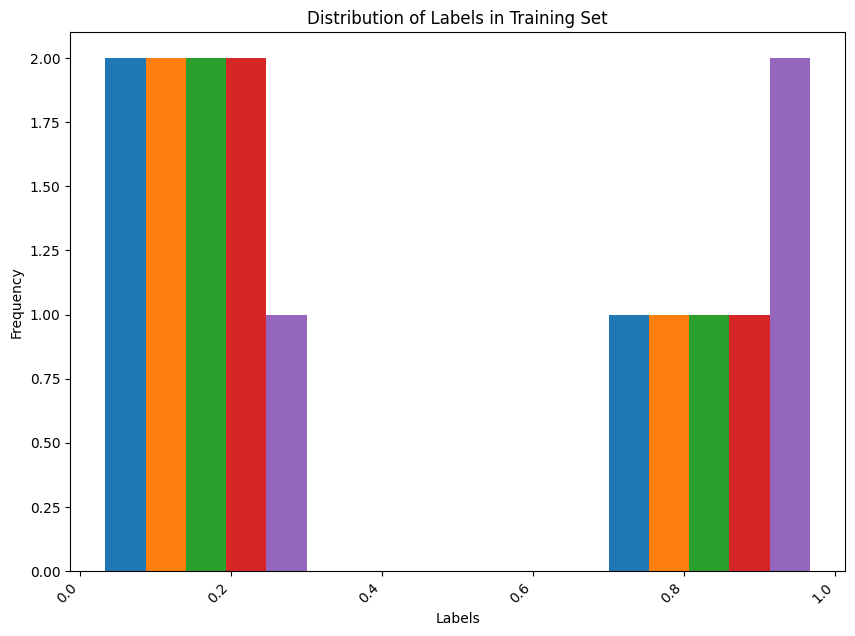

In [174]:
# Plot the data
plt.figure(figsize=(10, 7))

# Convert y_train to a list of tuples for hashability
y_train_hashable = [tuple(row) for row in y_train]

plt.hist(y_train_hashable, bins=len(set(y_train_hashable)))  # Plot histogram of labels
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in Training Set')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.show()

In [175]:
# Early Stopping Parameters
best_val_loss = float('inf')  # Initialize with a very large value
patience = 3  # Number of epochs to wait for improvement
epochs_without_improvement = 0

In [176]:
# Example Usage
model = TreeClassifier(num_classes=3, dropout_rate=dropout_rate).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


epochs = 10

start = timer()


for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in data_loader:
        # Retrieve data from batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass: Get predictions from the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Shape: [batch_size, num_classes]

        # Collect predictions and true labels
        # Convert model outputs to multi-label predictions using a threshold
        threshold = 0.5  # Adjust as needed
        preds = (outputs > threshold).cpu().numpy()  # Apply threshold to get multi-label predictions
        all_preds.extend(preds)  # Store all predictions
        all_labels.extend(labels.cpu().numpy())  # Store all true labels

        # Compute loss
        loss = criterion(outputs, labels.float())

        # Backward pass: Optimize the model
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update weights

        total_loss += loss.item()

    # Calculate overall accuracy for the epoch
    #epoch_accuracy = compute_accuracy(all_labels, all_preds)
    epoch_hamming_loss = hamming_loss(all_labels, all_preds)

    # Logging the loss and accuracy for this epoch
    avg_loss = total_loss / len(data_loader)
    if (epoch + 1) % 1 == 0:  # print every epoch (adjust the '1' to control frequency)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Hamming Loss: {epoch_hamming_loss:.4f}")

    # Validation Phase (Calculate val_loss)
    model.eval()
    val_loss = 0  # Initialize validation loss
    with torch.no_grad():
        for val_batch in data_loader:
            input_ids = val_batch['input_ids'].to(device)
            attention_mask = val_batch['attention_mask'].to(device)
            labels = val_batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Compute loss
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

    val_loss /= len(data_loader)  # Average validation loss
    print(f"Validation Loss: {val_loss:.4f}")  # Print validation loss

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the model's state_dict (optional)
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break


end = timer()
print_train_time(start, end, device)

Epoch 1/200, Loss: 0.7731, Hamming Loss: 0.4667
Validation Loss: 0.7634
Epoch 2/200, Loss: 0.7639, Hamming Loss: 0.3333
Validation Loss: 0.7577
Epoch 3/200, Loss: 0.7592, Hamming Loss: 0.3333
Validation Loss: 0.7553
Epoch 4/200, Loss: 0.7538, Hamming Loss: 0.3333
Validation Loss: 0.7523
Epoch 5/200, Loss: 0.7537, Hamming Loss: 0.3333
Validation Loss: 0.7483
Epoch 6/200, Loss: 0.7512, Hamming Loss: 0.3333
Validation Loss: 0.7436
Epoch 7/200, Loss: 0.7453, Hamming Loss: 0.3333
Validation Loss: 0.7378
Epoch 8/200, Loss: 0.7389, Hamming Loss: 0.3333
Validation Loss: 0.7309
Epoch 9/200, Loss: 0.7339, Hamming Loss: 0.3333
Validation Loss: 0.7224
Epoch 10/200, Loss: 0.7264, Hamming Loss: 0.3333
Validation Loss: 0.7141
Epoch 11/200, Loss: 0.7222, Hamming Loss: 0.3333
Validation Loss: 0.7044
Epoch 12/200, Loss: 0.7097, Hamming Loss: 0.2667
Validation Loss: 0.6980
Epoch 13/200, Loss: 0.7133, Hamming Loss: 0.3333
Validation Loss: 0.6951
Epoch 14/200, Loss: 0.7076, Hamming Loss: 0.2000
Validation 

KeyboardInterrupt: 

In [178]:
def predict_single_text(model, tokenizer, text, device, max_len=128, threshold=0.5):
    model.eval()
    with torch.no_grad():
        # Tokenize input text
        encoding = tokenizer(
            text,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get predictions
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = output.cpu().numpy()[0]
        predicted_labels = [i for i, prob in enumerate(probabilities) if prob > threshold]

    return predicted_labels, probabilities

# Example Usage
texts = ["What about a sandwich?", "example text 1 y"]
for text in texts:
  thresholds = [0.3, 0.4, 0.5, 0.6]
  for threshold in thresholds:
    predicted_labels, probabilities = predict_single_text(model, tokenizer, text, device, threshold=threshold)
    print(f"Threshold: {threshold}, Predicted Labels: {[label_names[i] for i in predicted_labels]}, Probabilities: {probabilities}")
    print(getResponse(predicted_labels, threshold))


Threshold: 0.3, Predicted Labels: ['p class'], Probabilities: [0.27584076 0.20777488 0.69839764]
p class (trashold: 0.3)
Threshold: 0.4, Predicted Labels: ['p class'], Probabilities: [0.27584076 0.20777488 0.69839764]
p class (trashold: 0.4)
Threshold: 0.5, Predicted Labels: ['p class'], Probabilities: [0.27584076 0.20777488 0.69839764]
p class (trashold: 0.5)
Threshold: 0.6, Predicted Labels: ['p class'], Probabilities: [0.27584076 0.20777488 0.69839764]
p class (trashold: 0.6)
Threshold: 0.3, Predicted Labels: ['y class', 'p class'], Probabilities: [0.97213644 0.01106302 0.9802633 ]
y class p class (trashold: 0.3)
Threshold: 0.4, Predicted Labels: ['y class', 'p class'], Probabilities: [0.97213644 0.01106302 0.9802633 ]
y class p class (trashold: 0.4)
Threshold: 0.5, Predicted Labels: ['y class', 'p class'], Probabilities: [0.97213644 0.01106302 0.9802633 ]
y class p class (trashold: 0.5)
Threshold: 0.6, Predicted Labels: ['y class', 'p class'], Probabilities: [0.97213644 0.01106302 